# 1. What are Dasked Arrays?
Dask arrays are specialized data structures that can be stored in **chunks**. The idea of dask arrays is that they consist of multiple numpy arrays, which are stored in chunks. Below we can see a grid of multiple numpy arrays. Each block in the dask array is an individual numpy array. So, we have essentially taken one very large numpy array (which would have not been able to fit into memory) and broken it down into small manageable chunks (that can fit into memory).   

<img src="https://intuitive-ml-images.s3-us-west-1.amazonaws.com/computer_science/libraries-tools/dask/dask_array.png" width="400">

The interface to dask arrays is similar to the numpy API, which makes it easy for developers to use dask arrays. Also, dask has specialized **blocked algorithms** that work on these dask arrays to perform computations. Dask will also make use of multiple cores in your system in order to parallelize the computation on these dask arrays. Now, since we can break a large array into smaller manageable chunks, this allows us to perform out of memory computation. So, even if your RAM is only 4 GB you can load data sets larger than that by breaking it into smaller manageable chunks. 

# 1.1 Introduction to Blocked Algorithms
Blocks algorithms are algorithms that basically work on **blocks** or **chunks** of data. They break the computation into smaller manageable parts, then they move on to aggregating the results between these chunks. Dask provides specialized algorithms to work with Dask Array, Dask Dataframes, and so on. For reference, the original paper can be found [here](http://conference.scipy.org/proceedings/scipy2015/pdfs/matthew_rocklin.pdf). 

Let's go through a hypothetical example. Suppose we have the following array, and we want to determine total sum of the values, and for the sake of simplicity it cannot be loaded into memory:

<img src="https://intuitive-ml-images.s3-us-west-1.amazonaws.com/computer_science/libraries-tools/dask/dask_blocked_algorithm.png" width="600">

What can be done is that we can break this array into chunks of three (a mapping stage), sum the individual chunks, and then reduce/aggregate the chunk summations into a final sum (`79`).

# 2. Examples

In [1]:
import numpy as np
import dask.array as da

## 2.1 Dask Array interface
We can see that it is similar to the numpy API:

In [3]:
np_arr = np.random.randint(20, size=20)
np_arr

array([ 4, 17,  1, 11,  4, 15, 18,  0, 14,  9,  6, 14, 14,  3,  4,  3,  6,
        2, 16,  0])

We simply need to add the additional attribute `chunks`:

In [6]:
dask_arr = da.random.randint(20, size=20, chunks=3)
dask_arr

dask.array<randint, shape=(20,), dtype=int64, chunksize=(3,)>

We can see that the dask array has _not_ been computed yet! That is because dask does lazy evaluation. In order to ensure that computation occurs, we must call the `compute()` function:

In [7]:
dask_arr.compute()

array([17,  8,  1, 13,  6,  7,  7,  4, 16,  4, 13, 16, 12,  9, 14,  6, 17,
       14, 13,  8])

We can also see how the chunk size effects the array:

In [11]:
dask_arr = da.random.randint(20, size=22, chunks=5)
dask_arr

dask.array<randint, shape=(22,), dtype=int64, chunksize=(5,)>

In [12]:
dask_arr.chunks

((5, 5, 5, 5, 2),)

We can also create dask arrays from existing data:

In [25]:
dask_arr_from_np = da.from_array(np_arr, chunks=5)
dask_arr_from_np

dask.array<array, shape=(20,), dtype=int64, chunksize=(5,)>

In [26]:
dask_arr_from_np.compute()

array([ 4, 17,  1, 11,  4, 15, 18,  0, 14,  9,  6, 14, 14,  3,  4,  3,  6,
        2, 16,  0])

In [27]:
np.testing.assert_array_equal(dask_arr_from_np.compute(), np_arr)

## 2.2 Dask translates your array operations in a graph of tasks
See [here](https://docs.dask.org/en/latest/graphviz.html) for more detail. An example is shown below. We have original array represented by the box on the left, it is broken down into 4 chunks of 5 elements, the sum is calculated for each individual chunk, and these sums are then aggregated to get the final result.  

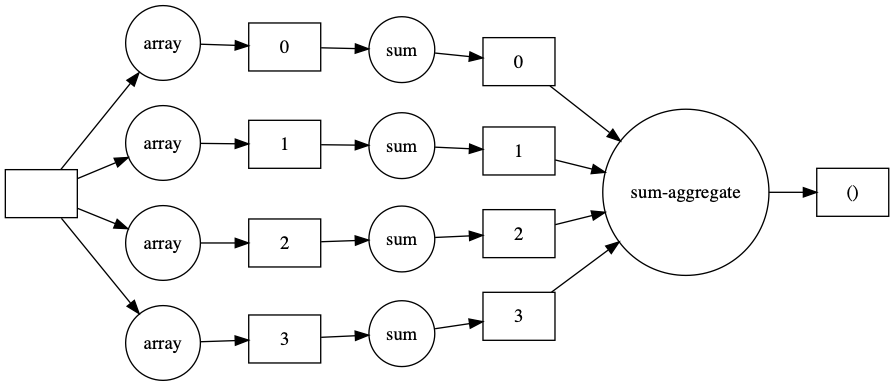

In [35]:
dask_arr_from_np.sum().visualize(rankdir="LR")

Another example is shown below (where we are performing an element wise addition of 1):

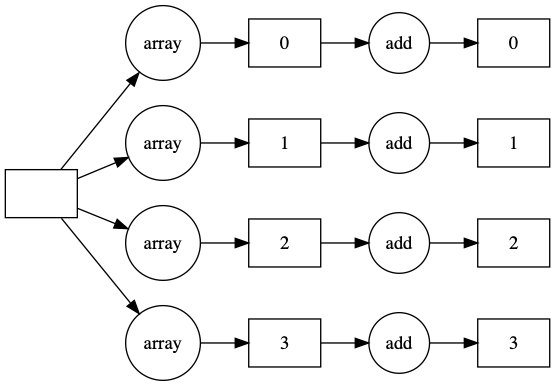

In [36]:
(dask_arr_from_np + 1).visualize(rankdir="LR")

Notice that above the results are _not_ aggregating to a single value; this is because we were calculating a sum previously (requiring an aggregation), where as this is a simple vector operation where we do not require aggregation. 

In [37]:
dask_arr_mean = da.mean(dask_arr_from_np)
dask_arr_mean.compute()

8.05

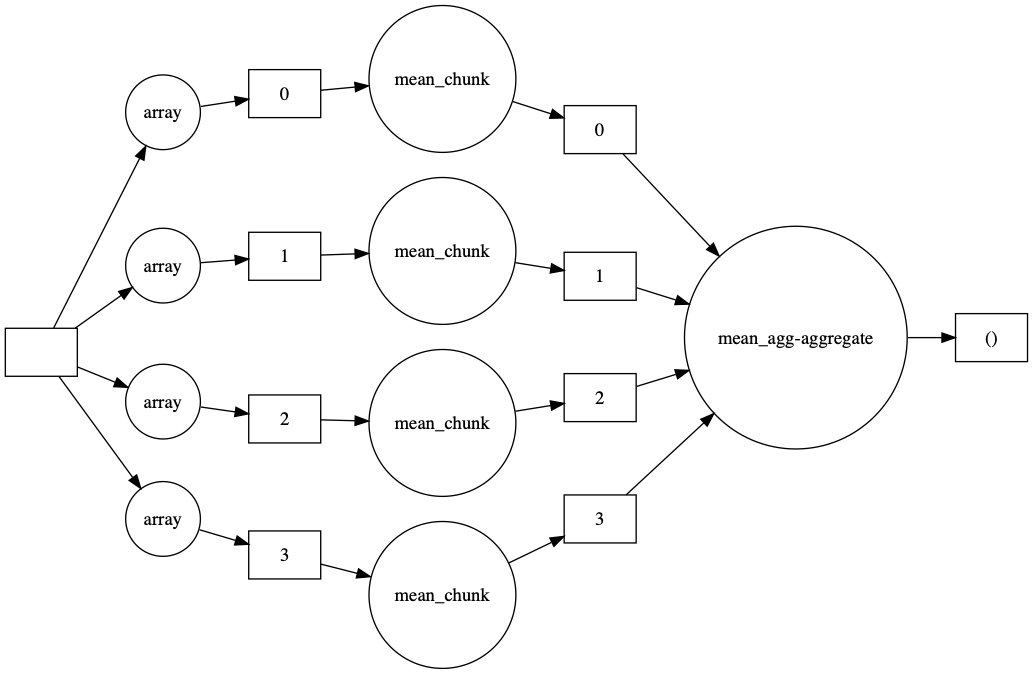

In [38]:
dask_arr_mean.visualize(rankdir="LR")

Again, we can see that 4 chunks are created, the mean is calculated over each individual chunk, and then these means are aggregated to get the final mean. We will discuss these task graphs more when dig into how dask performs parallelization of our code. 

## 2.3 Another Example

In [39]:
x = da.random.random(10, chunks=2) # x and y are both 10 element dask arrays
y = da.random.random(10, chunks=2)

# similar to numpy add, equivalent to x + y (since the dask array class must have an __add__ implied method)
sum_x_y = da.add(x, y) 
mean_x_y = da.mean(sum_x_y)

In [48]:
sum_x_y.compute()

array([0.40948846, 1.2043116 , 0.85120033, 1.31519518, 0.47089373,
       0.28989264, 0.66799714, 1.2408863 , 0.52599841, 0.6158717 ])

Let's look at how the addition is performed:

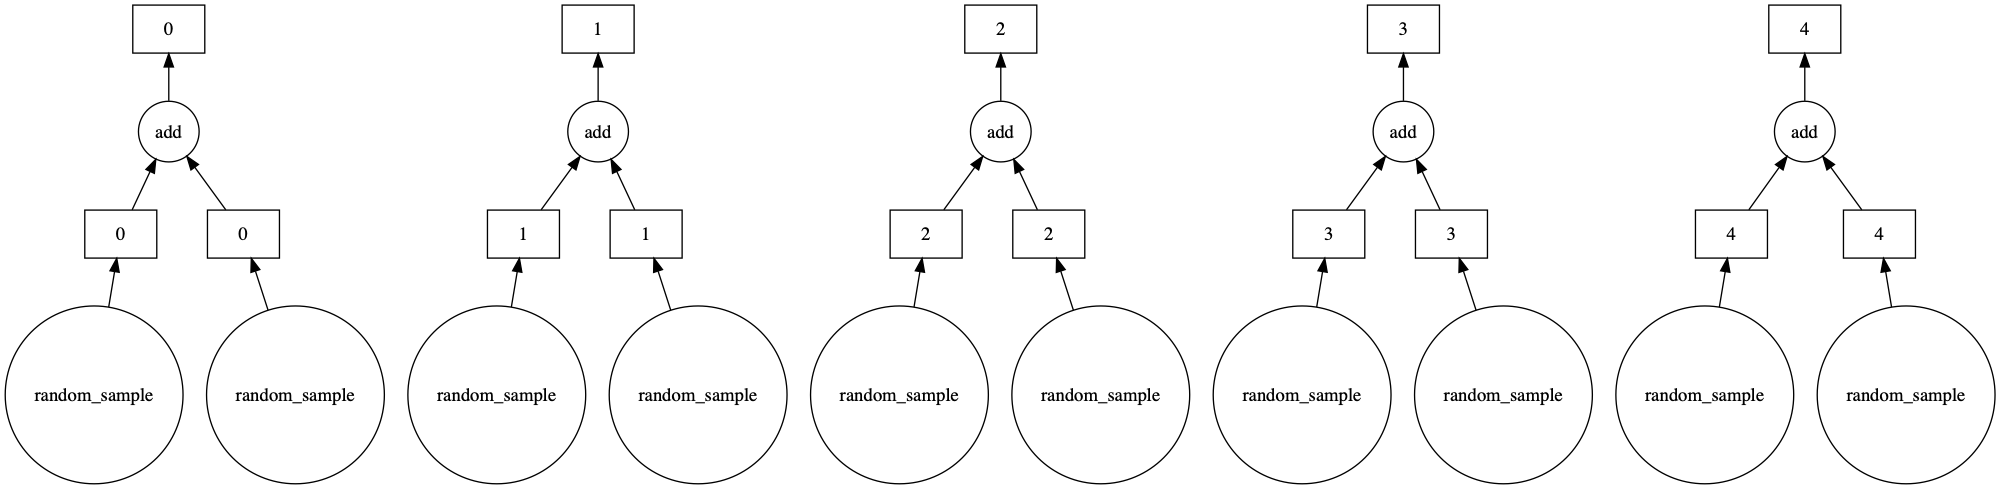

In [47]:
sum_x_y.visualize()

So first we see that the random `x` and `y` dask arrays are created. Then individually these chunks of 2 elements each are added. Because this is a vector operation they are not aggregating towards one value. The point here is that this operation can be done in parallel. Each individual process (5 total, shown above) run in parellel since they are note dependent on one another. A more appropriate term would be vectorized operation. 

Next we can look at the mean computation:

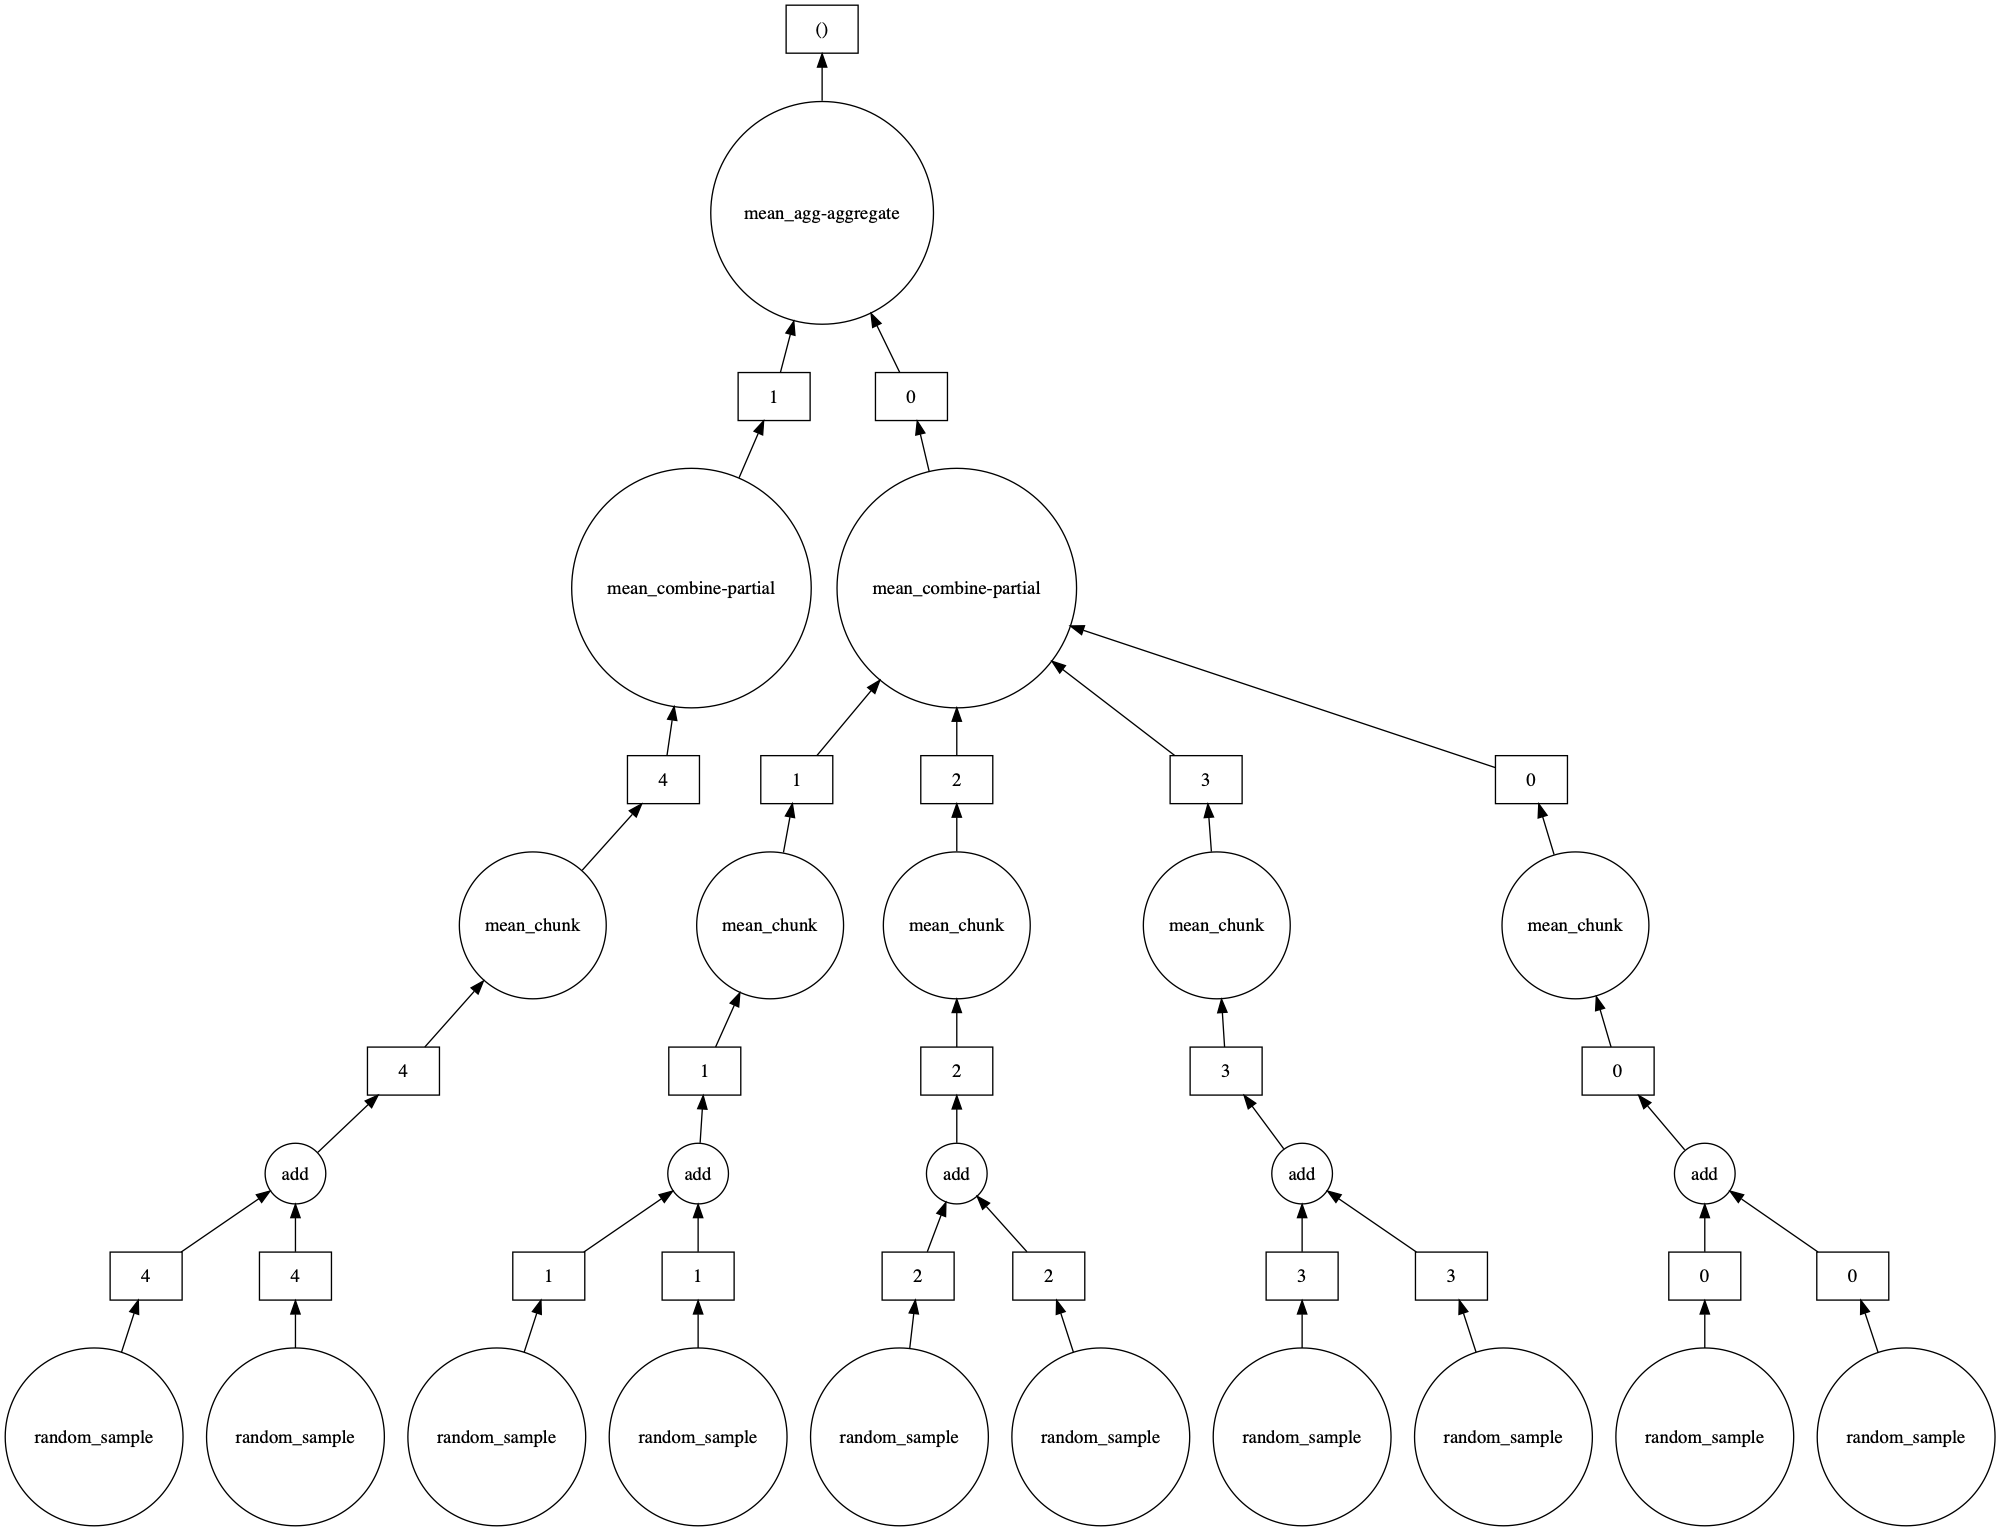

In [49]:
mean_x_y.visualize()

Here we have individual chunks which are added. Then, once you have the sum for each chunk you get the mean for that particular chunk. After that the partial means are aggregated, until we get one final mean. As more complex operations are performed our task graphs will get more complex. 

# 3. Example: Out of Memory Computation

In [50]:
da_arr_large = da.random.randint(10_000, size=(50_000, 50_000), chunks=(5_000, 5_000))

da_sum_large = da_arr_large.sum()

We can get the number of bytes using the `nbytes` attribute:

In [53]:
print("Size of array: ", da_arr_large.nbytes / 1e9, " GB.")

Size of array:  20.0  GB.


I only have 16 GB of RAM, and the array is 20 GB. Yet, this computation can easily be performed:

In [55]:
%%time 
da_sum_large.compute()

CPU times: user 1min 6s, sys: 10.9 s, total: 1min 17s
Wall time: 11.6 s


12498768718662

Note, what is also interesting: I used the `%%time` magic command and we can see that our CPU times were 1 minute and 17 seconds, yet out wall time was only 11.6 seconds. This is because under the hood dask _parallelized_ these operations and made use of additional CPU cores. 

In [56]:
77 / 11

7.0